# 230 Project Milestone

Original Data: https://paperswithcode.com/dataset/liar

Dataset Description: https://www.kaggle.com/datasets/doanquanvietnamca/liar-dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder



In [2]:
column_names = [
    "ID",
    "label",
    "statement",
    "subject(s)",
    "speaker",
    "speaker's job title",
    "state info",
    "party affiliation",
    "barely true counts",
    "false counts",
    "half true counts",
    "mostly true counts",
    "pants on fire counts",
    "context"
]

train_df = pd.read_csv('train.tsv', sep='\t', header = None, names=column_names)
val_df = pd.read_csv('valid.tsv', sep='\t', header = None, names=column_names)
test_df = pd.read_csv('test.tsv', sep='\t', header = None, names=column_names)


train_df.head()


,ID,label,statement,subject(s),speaker,speaker's job title,state info,party affiliation,barely true counts,false counts,half true counts,mostly true counts,pants on fire counts,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [3]:
print(len(train_df))
print(len(val_df))
print(len(test_df))

10240
1284
1267


In [5]:
# look at examples

train_df.iloc[0]


,0
ID,2635.json
label,false
statement,Says the Annies List political group supports ...
subject(s),abortion
speaker,dwayne-bohac
speaker's job title,State representative
state info,Texas
party affiliation,republican
barely true counts,0.0
false counts,1.0


In [6]:
# prompt: look for examples in the train_df that were spoken by trump (includes the trump string)

train_df[train_df['statement'].str.contains('trump')]['statement'].iloc[0]


'Assault weapons and handguns are allowed in the state Capitol while bullhorns, trumpets, helium balloons and flags on poles are banned.'

In [7]:
label_mapping = {
    'true': 'True/Mostly True',
    'mostly-true': 'True/Mostly True',
    'half-true': 'Partially True',
    'barely-true': 'Partially True',
    'false': 'False',
    'pants-fire': 'False'
}

train_df['grouped_label'] = train_df['label'].map(label_mapping)
val_df['grouped_label'] = val_df['label'].map(label_mapping)
test_df['grouped_label'] = test_df['label'].map(label_mapping)


<ipython-input-9-24418d20ee37>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, count + 0.5, f'{percentages[i]:.1f}%', ha='center')


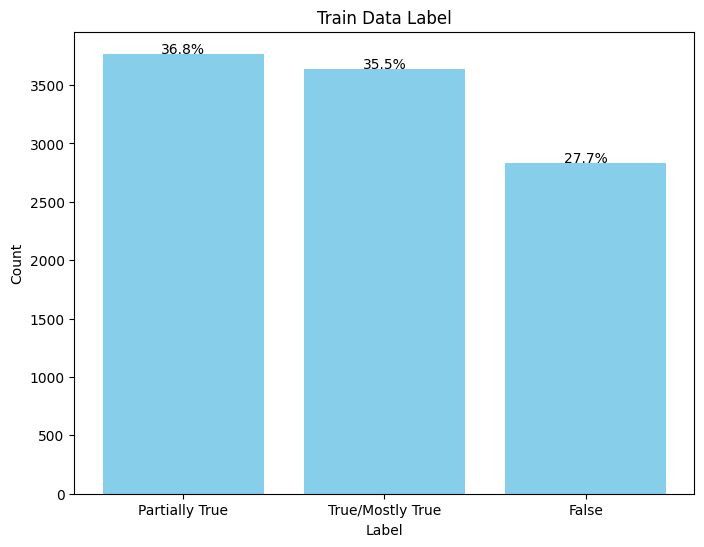

<ipython-input-9-24418d20ee37>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, count + 0.5, f'{percentages[i]:.1f}%', ha='center')


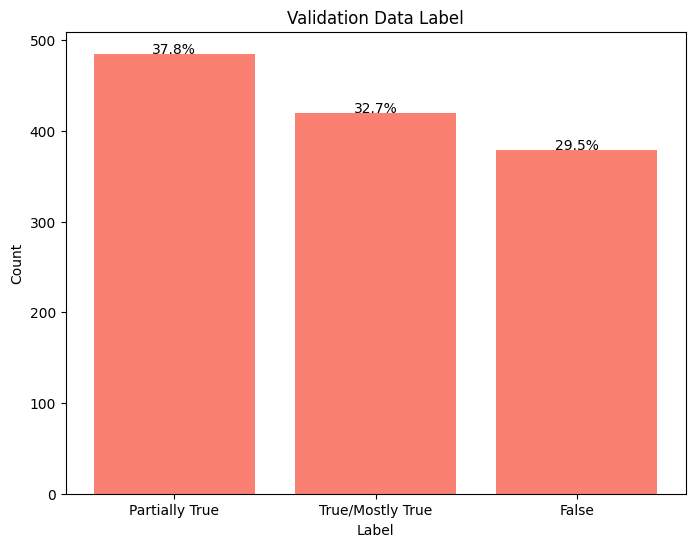

<ipython-input-9-24418d20ee37>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, count + 0.5, f'{percentages[i]:.1f}%', ha='center')


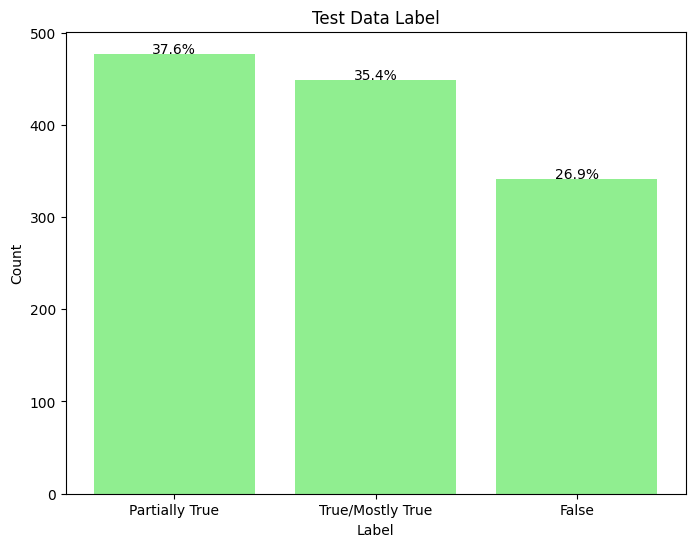

In [9]:
def plot_label_distribution(df, title, color, label_column='grouped_label'):
    counts = df[label_column].value_counts()
    percentages = df[label_column].value_counts(normalize=True) * 100

    plt.figure(figsize=(8, 6))
    plt.bar(counts.index, counts.values, color=color)
    plt.title(f'{title} Label')
    plt.xlabel('Label')
    plt.ylabel('Count')

    for i, count in enumerate(counts):
        plt.text(i, count + 0.5, f'{percentages[i]:.1f}%', ha='center')

    plt.show()

plot_label_distribution(train_df, 'Train Data', 'skyblue')
plot_label_distribution(val_df, 'Validation Data', 'salmon')
plot_label_distribution(test_df, 'Test Data', 'lightgreen')


In [10]:
X_train = train_df['statement']
y_train = train_df['grouped_label']

X_val = val_df['statement']
y_val = val_df['grouped_label']

X_test = test_df['statement']
y_test = test_df['grouped_label']


# Baseline

* Logistic Regression with TF-IDF
* Not utilizing any other features for now, just statement

In [11]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

logreg_model = LogisticRegression()
logreg_model.fit(X_train_tfidf, y_train)


LogisticRegression()

In [12]:
# evaluate on validation

y_val_pred = logreg_model.predict(X_val_tfidf)
print(classification_report(y_val, y_val_pred))

# evalute and test

y_test_pred = logreg_model.predict(X_test_tfidf)
print(classification_report(y_test, y_test_pred))

                  precision    recall  f1-score   support

           False       0.43      0.29      0.35       379
  Partially True       0.41      0.46      0.43       485
True/Mostly True       0.43      0.50      0.46       420

        accuracy                           0.42      1284
       macro avg       0.42      0.42      0.42      1284
    weighted avg       0.42      0.42      0.42      1284

                  precision    recall  f1-score   support

           False       0.40      0.30      0.34       341
  Partially True       0.43      0.45      0.44       477
True/Mostly True       0.44      0.50      0.47       449

        accuracy                           0.43      1267
       macro avg       0.42      0.42      0.42      1267
    weighted avg       0.42      0.43      0.42      1267



We see roughly comprable performance across classes, with slightly better performance on the "True/Mostly True" category. Accuracy is pretty disappointing.

# LSTM

* Not considering other features for now
* No hyperparameter tuning-- we will likely need to in order to beat out the logistic regression
resource: https://nzlul.medium.com/the-classification-of-text-messages-using-lstm-bi-lstm-and-gru-f79b207f90ad

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [14]:

# do label encoding for the "label" outcome to have numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

In [15]:
# get some statistics of the dataset

for name, dataset in {'X_train': X_train, 'X_val': X_val, 'X_test': X_test}.items():
    lengths = [len(i.split()) for i in dataset]
    avg_length = sum(lengths) / len(dataset)
    max_length = max(lengths)
    percentile_length = np.percentile(lengths, 95)

    print(f"Average length of statement in {name}: {avg_length:.2f}")
    print(f"Maximum length of statement in {name}: {max_length}")
    print(f"95th Percentile Length of statements in {name}: {percentile_length:.2f}")
    print("\n")

# looks like we should use length 40 padding to be safe

Average length of statement in X_train: 18.01
Maximum length of statement in X_train: 467
95th Percentile Length of statements in X_train: 33.00


Average length of statement in X_val: 17.93
Maximum length of statement in X_val: 57
95th Percentile Length of statements in X_val: 32.00


Average length of statement in X_test: 18.40
Maximum length of statement in X_test: 431
95th Percentile Length of statements in X_test: 32.00




In [16]:
tokenizer = Tokenizer(num_words=5000, oov_token="<UNK>")
# HP to tune for later is num_words
# for now selected 5000 as recommended by resources online

tokenizer.fit_on_texts(X_train)
# fit tokenizer to training data

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)
# convert the texts to sequences for LSTM

In [18]:
pad_length = 40 # set this because of the averages/percentiles observed previously
# can also try overall max length later, depending on how long it takes
# pre padding recommended for LSTMs

X_train_pad = pad_sequences(X_train_seq, padding='pre', maxlen=pad_length)
X_val_pad = pad_sequences(X_val_seq, padding='pre', maxlen=pad_length)
X_test_pad = pad_sequences(X_test_seq, padding='pre', maxlen=pad_length)

print(X_train_pad.shape)
print(X_val_pad.shape)
print(X_test_pad.shape)

(10240, 40)
(1284, 40)
(1267, 40)


In [19]:
# for now choose 100 dim as embedding layer, good for smaller(ish) model
# 128 is typical for LSTM
# relu activation
# sparse categorical crossentropy loss for integer labels

dropout_prob = 0.2
num_classes = 3
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=100, input_length=pad_length))
model.add(LSTM(128, dropout=dropout_prob, recurrent_dropout=dropout_prob))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',  optimizer=Adam(), metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [20]:
# use early stopping
# stop after loss increases after 3 epochs

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
history = model.fit(X_train_pad, y_train_encoded, epochs=10, batch_size=32, validation_data=(X_val_pad, y_val_encoded),
                    callbacks=[early_stopping])

Epoch 1/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 26s 55ms/step - accuracy: 0.3913 - loss: 1.0834 - val_accuracy: 0.4276 - val_loss: 1.0638
Epoch 2/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step - accuracy: 0.5045 - loss: 0.9989 - val_accuracy: 0.4283 - val_loss: 1.0843
Epoch 3/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step - accuracy: 0.6315 - loss: 0.8310 - val_accuracy: 0.4003 - val_loss: 1.1557
Epoch 4/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.7087 - loss: 0.6892 - val_accuracy: 0.4003 - val_loss: 1.3532
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


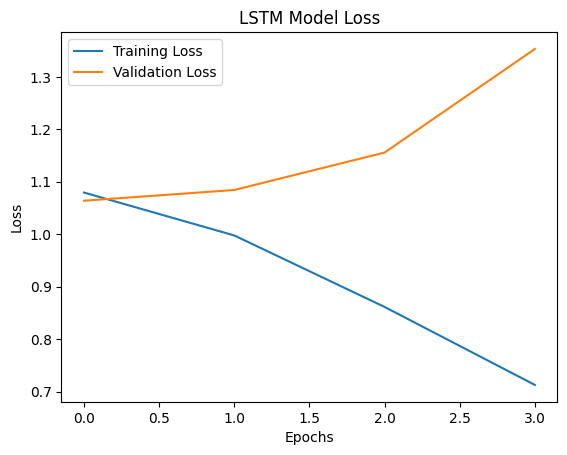

In [21]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Looks like model is overfitting
# training accuracy and loss are showing improvement across epochs
# validation set does not reflect this, so may be overfitting

In [22]:
y_test_pred = model.predict(X_test_pad)
y_test_pred = np.argmax(y_test_pred, axis=1)
print(classification_report(y_test_encoded, y_test_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test_encoded, y_test_pred)
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
print("\nConfusion Matrix:")
print(cm_df)

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
                  precision    recall  f1-score   support

           False       0.38      0.35      0.36       341
  Partially True       0.40      0.39      0.39       477
True/Mostly True       0.46      0.49      0.48       449

        accuracy                           0.42      1267
       macro avg       0.41      0.41      0.41      1267
    weighted avg       0.42      0.42      0.42      1267


Confusion Matrix:
                  False  Partially True  True/Mostly True
False               119             133                89
Partially True      120             188               169
True/Mostly True     73             154               222


# Pre Trained BERT


* We will compare the results to pre-trained BERT
* Tutorial: https://www.tensorflow.org/text/tutorials/classify_text_with_bert
* Will use DistilBERT for faster training

In [29]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset



In [33]:
X_train = train_df['statement']
y_train = train_df['grouped_label']

X_val = val_df['statement']
y_val = val_df['grouped_label']

X_test = test_df['statement']
y_test = test_df['grouped_label']


tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

X_train_tokenized = tokenizer(list(X_train), padding="max_length", truncation=True, max_length=128)
X_val_tokenized = tokenizer(list(X_val), padding="max_length", truncation=True, max_length=128)
X_test_tokenized = tokenizer(list(X_test), padding="max_length", truncation=True, max_length=128)


In [34]:
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(X_train_tokenized, y_train_encoded)
val_dataset = SentimentDataset(X_val_tokenized, y_val_encoded)
test_dataset = SentimentDataset(X_test_tokenized, y_test_encoded)


In [36]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(label_encoder.classes_))


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {"accuracy": accuracy_score(labels, preds)}

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,1.055100,1.023083,0.466511
2,0.923800,1.048371,0.472741
3,0.712300,1.222694,0.456386
4,0.438000,1.665882,0.463396
5,0.266200,2.649070,0.465732
6,0.180700,3.494674,0.461838
7,0.092000,3.967859,0.456386
8,0.091900,4.360895,0.459502


Epoch,Training Loss,Validation Loss,Accuracy
1,1.055100,1.023083,0.466511
2,0.923800,1.048371,0.472741
3,0.712300,1.222694,0.456386
4,0.438000,1.665882,0.463396
5,0.266200,2.649070,0.465732
6,0.180700,3.494674,0.461838
7,0.092000,3.967859,0.456386
8,0.091900,4.360895,0.459502
9,0.060300,4.603684,0.461838
10,0.037900,4.665256,0.458723


TrainOutput(global_step=12800, training_loss=0.38365409091115, metrics={'train_runtime': 1562.4741, 'train_samples_per_second': 65.537, 'train_steps_per_second': 8.192, 'total_flos': 3391225882214400.0, 'train_loss': 0.38365409091115, 'epoch': 10.0})

In [38]:
# evaluate on test
test_results = trainer.evaluate(test_dataset)
print(test_results)

predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(-1)
y_true = predictions.label_ids
print(classification_report(y_true, predicted_labels, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true, predicted_labels)
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
print("\nConfusion Matrix:")
print(cm_df)


{'eval_loss': 1.0280379056930542, 'eval_accuracy': 0.4593528018942384, 'eval_runtime': 4.7877, 'eval_samples_per_second': 264.634, 'eval_steps_per_second': 33.21, 'epoch': 10.0}
                  precision    recall  f1-score   support

           False       0.42      0.32      0.36       341
  Partially True       0.44      0.42      0.43       477
True/Mostly True       0.49      0.61      0.54       449

        accuracy                           0.46      1267
       macro avg       0.45      0.45      0.45      1267
    weighted avg       0.45      0.46      0.45      1267


Confusion Matrix:
                  False  Partially True  True/Mostly True
False               108             119               114
Partially True      105             199               173
True/Mostly True     43             131               275


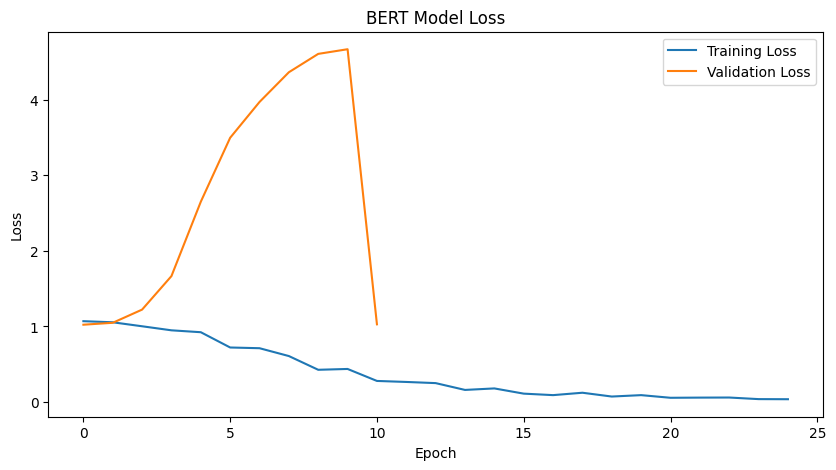

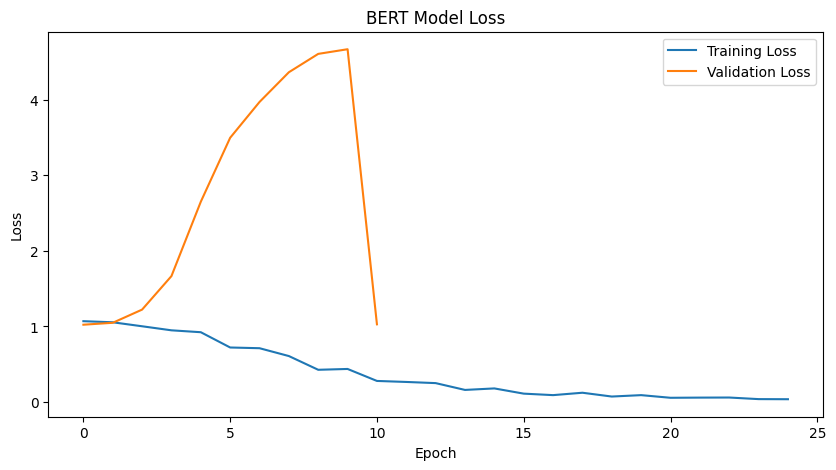

In [40]:
train_loss = trainer.state.log_history
train_losses = [log['loss'] for log in train_loss if 'loss' in log]
eval_losses = [log['eval_loss'] for log in train_loss if 'eval_loss' in log]

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(eval_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('BERT Model Loss')
plt.legend()
plt.show()
